# 1.0 Tic Tac Toe Environment Setup

## 1.1 Import Packages

In [139]:
import numpy as np
import gym
from gym import spaces
import itertools

## 1.2 TicTacToe Class

In [140]:
class TicTacToe():

    def __init__(self):
        self.length = 3                           # grid dimension
        self.n_states = 3 ** (self.length ** 2)   # number of possible states (-1, 0, 1) at each grid
        self.n_actions = self.length ** 2         # number of possible actions

        # self.observation_space = spaces.MultiDiscrete([3] * 9, dtype=np.int32) # all combinations of {0, 1, 2} ^ 9
        self.observation_space = spaces.MultiDiscrete([3] * 9) # all combinations of {0, 1, 2} ^ 9

        # Get a bijection for state IDs and their array representations
        state_combinations = list(itertools.product(*[list(range(-1, k - 1)) for k in self.observation_space.nvec])) # {-1, 0, 1}
        self.state_arr_to_id = {''.join(list(map(str, state_combinations[i]))): i for i in range(len(state_combinations))}
        self.state_id_to_arr = {i: state_combinations[i] for i in range(len(state_combinations))}
        self.reset()

    def reset(self):
        self.states = np.zeros((self.length,self.length),np.int8)
        self.n_occupied = 0
        return self._get_state_id(self.states)

    def step(self, a: int):
        '''
        reward r: -1 for each step, 100 for winning, -100 for losing
        return reward, game ended, win or lose
        r, 1, 1 -> player 1 wins
        r, 1, 1 -> player 1 lose
        r, 1, 0 -> draw
        r, 0, 0 -> game not ended
        '''
        assert 0 <= a and a < self.n_actions

        reward = -1
        x, y = self.actionToXY(a)
        if self.states[y][x] == 0:
            # RL agent
            self.states[y][x] = 1
            self.n_occupied += 1
            next_state_id = self._get_state_id(self.states)  # get new state id
            if self._terminal() == 1:
                reward += 100
                return next_state_id, reward, 1, 1
            elif self.n_occupied == self.length * self.length:
                return next_state_id, reward, 1, 0
            # Random move from opponent
            a = self.randomMove()
            x, y = self.actionToXY(a)
            self.states[y][x] = -1
            self.n_occupied += 1
            next_state_id = self._get_state_id(self.states)  # get new state id
            if self._terminal() == -1:
                reward -= 100
                return next_state_id, reward, 1, -1
            else:
                return next_state_id, reward, 0, 0       
        else:
            next_state_id = self._get_state_id(self.states)
            return next_state_id, reward, 0, 0

    def _terminal(self):
        '''
          return  1 if player 1 wins,
                  -1 if player -1 wins,
                  0 if no one wins
        '''
        if max(np.max(np.sum(self.states, axis=0)), np.max(np.sum(self.states, axis=1)), np.trace(self.states), np.trace(np.fliplr(self.states))) == 3:
            return 1
        elif min(np.max(np.sum(self.states, axis=0)), np.max(np.sum(self.states, axis=1)), np.trace(self.states), np.trace(np.fliplr(self.states))) == -3:
            return -1
        else:
            return 0

    def actionToXY(self, a: int):
        '''
        convert a (1 to 9) to x and y coordinates
        '''
        x = a % 3
        y = a // 3
        return x, y

    def randomMove(self):
        '''
        return random action chosen from available ones with equal probability
        '''
        P = np.array(self.states.flatten() == 0)
        P = P / sum(P)
        a = np.random.choice(self.n_actions, p=P)
        return a

    def _get_state_id(self, state_arr: np.array):
        '''
        give state array return its id
        '''
        return self.state_arr_to_id[''.join(list(map(str, state_arr.flatten().tolist())))]

    def _print_horizontal(self):
        print("+--+--+--+")

    def display(self):
        for y in range(self.length):
            self._print_horizontal()
            for x in range(self.length):
                print("|",end="")
                print('{: >2d}'.format(self.states[y][x]),end="")
            print("|")
        self._print_horizontal()
        print()

    def seed(self, seed: int=None):
        if seed is not None:
            np.random.seed(seed)

# 2.0 Reinforcement Learning Implementation

## 2.1 Helper Functions

In [141]:
import math

In [142]:
def argmax_with_random_tiebreaking(v: np.array) -> int:
    '''
    Returns the argmax of a 1D numpy array, breaking ties randomly.
    :param v (np.array): A 1D numpy array
    :return: The argmax of v, with ties broken randomly
    '''
    return np.random.choice(np.where(v == v.max())[0])

In [143]:
def sample_integer_from_categorical_distribution(P: np.array) -> int:
    '''
    Sample an integer value from a categorical distribution P.
    :param P: A probability distribution represented as a numpy array with shape [n], where n is the number of possible
              values. That is, for each i in {0, 1, ..., n-1}, P[i] is the probability of sampling i.
    :return: The randomly sampled integer
    '''
    n = P.shape[0]
    return np.random.choice(np.arange(n), p=P)

## 2.2.0 Action Selection

In [144]:
def select_action(strategy: str, s: int, Q: np.array, N_sa: np.array, epsilon: float=0.05, T: float=10., N_e: int=5,
                  R_plus: float=999.):
    '''
    Selects an action for the current state according to the desired strategy. This may be of use to you for the
    Q-learning and SARSA functions.
    :param strategy: Action selection strategy for exploration - one of {"optimistic", "softmax", "epsilon_greedy"}
    :param s: The current state
    :param Q: A [n_states, n_actions] array where Q[s, a] is the action value for taking action a in state s
    :param N_sa: A [n_states, n_actions] array indicating the number of times that each state/action pair has been visited
    :param epsilon: The probability for selecting a random action (in [0, 1])
    :param T: The temperature for softmax action selection
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    '''

    if strategy == "optimistic":
        return select_action_optimistically(s, Q, N_sa, N_e, R_plus)
    elif strategy == "softmax":
        return select_action_softmax(s, Q, T)
    else:
        return select_action_epsilon_greedy(s, Q, epsilon)

### 2.2.1 Epsilon Greedy

In [145]:
def select_action_epsilon_greedy(s: int, Q: np.array, epsilon: float=0.1) -> int:
    '''
    With probability epsilon, select a random action. Otherwise, select the greedy action.
    :param s: The current state
    :param Q: A [n_states, n_actions] array where Q[s, a] is the action value for taking action a in state s
    :param epsilon: The probability for selecting a random action (in [0, 1])
    '''

    n_actions = Q.shape[1]
    Q_s = Q[s]
    p = np.array([epsilon, 1 - epsilon])
    i = sample_integer_from_categorical_distribution(p)
    if i:
        a = argmax_with_random_tiebreaking(Q[s])
    else:
        a = sample_integer_from_categorical_distribution(np.array([1/n_actions] * n_actions))
    return a

### 2.2.2 Softmax

In [146]:
def select_action_softmax(s: int, Q: np.array, T: float=10.0) -> int:
    '''
    Select an action via softmax selection using the Gibbs/Boltzmann distribution. Assumes that the temperature is
    always nonzero.
    :param s: The current state
    :param Q: A [n_states, n_actions] array where Q[s, a] is the action value for taking action a in state s
    :param T: The temperature (T != 0)
    '''

    n_actions = Q.shape[1]
    minQ = min(Q[s])
    maxQ = max(Q[s])
    if maxQ / T > 700:
        subtract = maxQ - 700 * T
    else:
        subtract = 0
    avgQ = np.average(Q[s])
    #p = np.array([math.exp((Q_val - minQ)/T) for Q_val in Q[s]])
    p = np.array([math.exp(int((Q_val - subtract)/T)) for Q_val in Q[s]])
    #p = [math.exp(Q_val/T) for Q_val in Q[s]]
    p = p / sum(p)
    a = sample_integer_from_categorical_distribution(p)
    return a

### 2.2.3 Optimistically

In [147]:
def select_action_optimistically(s: int, Q: np.array, N_sa: np.array, N_e: int=5, R_plus: np.float=999.0) -> int:
    '''
    Use optimistic utility estimates to select an action. If the
    :param s: The current state
    :param Q: A [n_states, n_actions] array where Q[s, a] is the action value for taking action a in state s
    :param N_sa: A [n_states, n_actions] array indicating the number of times that each state/action pair has been visited
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    '''

    f = np.array([Q_val if N_sa[s][i] >= N_e else R_plus for i, Q_val in enumerate(Q[s])])
    a = argmax_with_random_tiebreaking(f)
    return a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


## 2.3.0 Reinforcement Learning Algorithms

### 2.3.1 Active Q Learning

In [148]:
def active_q_learning(env: TicTacToe, Q_init: np.array, n_episodes: int, action_selection: str='optimistic',
                      discount_factor=0.99, alpha: float=0.5, epsilon: float=0.1, T: float=1., N_e: int=3,
                      R_plus: float=999.) -> (np.array, np.array):
    '''
    Conducts active Q-learning to learn optimal Q-values. Q-values are updated during each step for a fixed number of
    episodes.
    :param env: The environment with which the agent interacts
    :param Q_init [env.n_states, env.n_actions]: Initial action values
    :param n_episodes: The number of training episodes during which experience can be collected to learn the Q-values
    :param action_selection: Action selection strategy for exploration - one of {"optimistic", "softmax", "epsilon_greedy"}
    :param discount_factor: Discount factor, in (0, 1]
    :param alpha: Learning rate. alpha > 0.
    :param epsilon: The probability for selecting a random action (in [0, 1])
    :param T: The temperature for softmax action selection
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    :return: (Final Q-values after convergence [env.n_states, env.n_actions],
              Total undiscounted reward obtained in each episode [n_episodes])
    '''
    Q = Q_init
    N_sa = np.zeros((env.n_states, env.n_actions))
    episode_rewards = np.zeros((n_episodes))
    last1000 = {-1: 0, 0: 0, 1: 0}
    for i in range(n_episodes):
        if i % 10000 == 0:
          print("episode:{0} to {2}/{1}".format(i,n_episodes - 1, min(i + 9999, n_episodes - 1)))
        s = env.reset()
        game_ended = False
        reward = 0
        while (not game_ended):
            a = select_action(action_selection, s, Q, N_sa, epsilon, T, N_e, R_plus)
            s_prime, r, game_ended, status = env.step(a)
            reward += r
            Q[s][a] += alpha * (r + discount_factor * np.max(Q[s_prime]) - Q[s][a])
            N_sa[s][a] += 1
            s = s_prime
        episode_rewards[i] = reward
        if i + 1000 >= n_episodes:
            last1000[status] += 1
    return Q, episode_rewards, last1000

### 2.3.2 Active SARSA

In [149]:
def active_sarsa(env: TicTacToe, Q_init: np.array, n_episodes: int, action_selection: str='optimistic',
                 discount_factor: float=0.99, alpha: float=0.5, epsilon: float=0.1, T: float=1., N_e: int=3,
                 R_plus: float=999.) -> (np.array, np.array):
    '''
    Conducts active SARSA to learn optimal Q-values. Q-values are updated during each step for a fixed number of
    episodes.
    :param env: The environment with which the agent interacts
    :param Q_init: Initial action values
    :param n_episodes: The number of training episodes during which experience can be collected to learn the Q-values
    :param action_selection: Action selection strategy for exploration - one of {"optimistic", "softmax", "epsilon_greedy"}
    :param discount_factor: Discount factor, in (0, 1]
    :param alpha: Learning rate. alpha > 0.
    :param epsilon: The probability for selecting a random action (in [0, 1])
    :param T: The temperature for softmax action selection
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    :return: (Final Q-values after convergence [env.n_states, env.n_actions],
              Total undiscounted reward obtained in each episode [n_episodes])
    '''
    Q = Q_init
    N_sa = np.zeros((env.n_states, env.n_actions))
    episode_rewards = np.zeros((n_episodes))
    last1000 = {-1: 0, 0: 0, 1: 0}
    for i in range(n_episodes):
        if i % 10000 == 0:
          print("episode:{0} to {2}/{1}".format(i,n_episodes - 1, min(i + 9999, n_episodes - 1)))
        s = env.reset()
        game_ended = False
        reward = 0
        a = select_action(action_selection, s, Q, N_sa, epsilon, T, N_e, R_plus)
        while (not game_ended):
            # print("s={0}".format(s))
            s_prime, r, game_ended, status = env.step(a)
            a_prime = select_action(action_selection, s_prime, Q, N_sa, epsilon, T, N_e, R_plus)
            reward += r
            Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])
            N_sa[s][a] += 1
            s = s_prime
            a = a_prime
        episode_rewards[i] = reward
        if i + 1000 >= n_episodes:
            last1000[status] += 1

    return Q, episode_rewards, last1000

# 3.0 Main

## 3.1 Import Package

In [150]:
import matplotlib.pyplot as plt

## 3.2 Define Hyper Parameters

In [151]:
alpha = 0.5
discount_factor = 0.99
n_episodes = 50000
epsilon = 0.1
T = 0.1
N_e = 2
R_plus = 999

## 3.3 Run RL

In [152]:
window = 50
n_run = 3
rewards = np.zeros((3, n_episodes - window + 1))

In [153]:
def runRL(algo: str, strategy: str):
  '''
  algo = "SARSA" (or "Q")
  strategy = "optimistic" or "softmax" (or "greedy")
  '''
  for i in range(n_run):
    print("Program:{0}/{1}".format(i, n_run - 1))
    env = TicTacToe()
    env.seed(i)
    if algo == "SARSA":
      Q, episode_rewards, last1000 = active_sarsa(env, np.zeros((env.n_states, env.n_actions)), n_episodes, strategy,
                        discount_factor, alpha, epsilon, T, N_e, R_plus)
    else:
      Q, episode_rewards, last1000 = active_q_learning(env, np.zeros((env.n_states, env.n_actions)), n_episodes, strategy,
                        discount_factor, alpha, epsilon, T, N_e, R_plus)
    rewards[i] = np.convolve(episode_rewards, np.ones(window)/window, mode="valid")
  
  plt.plot(range(n_episodes - window + 1), np.average(rewards,axis=0))
  plt.title(algo + " + " + strategy)
  plt.xlabel("episode")
  plt.ylabel("reward")
  plt.show()
  plt.clf()
  print("Win:", last1000[1])
  print("Draw:", last1000[0])
  print("Lose:", last1000[-1])
  return Q, last1000

### 3.3.1 Active SARSA + Softmax

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


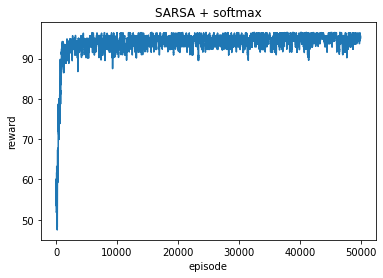

Win: 980
Draw: 20
Lose: 0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 0, 0: 20, 1: 980})

<Figure size 432x288 with 0 Axes>

In [156]:
runRL("SARSA", "softmax")

### 3.3.2 Active SARSA + Optimstic

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


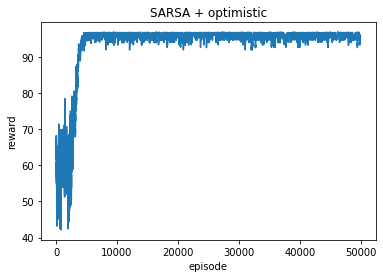

Win: 990
Draw: 10
Lose: 0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 0, 0: 10, 1: 990})

<Figure size 432x288 with 0 Axes>

In [135]:
runRL("SARSA", "optimistic")

### 3.3.3 Active Q Learning + Epsilon Greedy

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


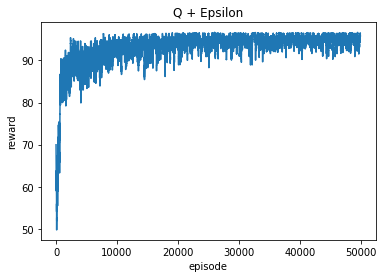

Win: 983
Draw: 14
Lose: 3


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 3, 0: 14, 1: 983})

<Figure size 432x288 with 0 Axes>

In [137]:
runRL("Q", "Epsilon")

### 3.3.4 Active Q Learning + Softmax

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


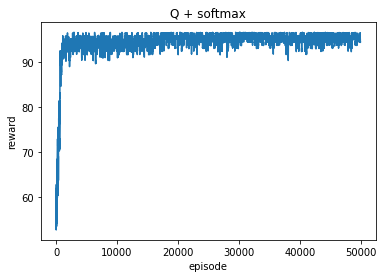

Win: 985
Draw: 15
Lose: 0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 0, 0: 15, 1: 985})

<Figure size 432x288 with 0 Axes>

In [136]:
runRL("Q", "softmax")

### 3.3.5 Active Q Learning + Optimistic

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


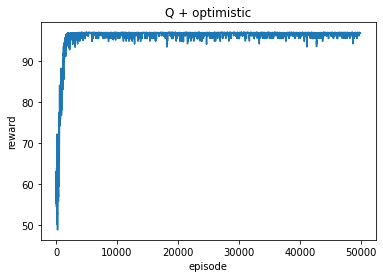

Win: 998
Draw: 2
Lose: 0


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 0, 0: 2, 1: 998})

<Figure size 432x288 with 0 Axes>

In [154]:
runRL("Q", "optimistic")

### 3.3.6 Active Q Learning + Epsilon Greedy

Program:0/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:1/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999
Program:2/2
episode:0 to 9999/49999
episode:10000 to 19999/49999
episode:20000 to 29999/49999
episode:30000 to 39999/49999
episode:40000 to 49999/49999


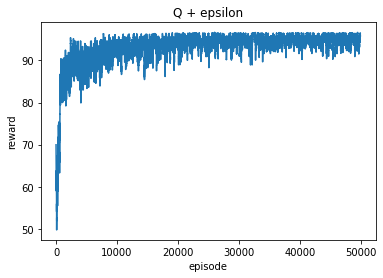

Win: 983
Draw: 14
Lose: 3


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), {-1: 3, 0: 14, 1: 983})

<Figure size 432x288 with 0 Axes>

In [155]:
runRL("Q", "epsilon")